In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [15]:
df = pd.read_csv('data/cleaned_rounds_data_with_stats.csv')
df.head()

,round_winner,team_1_position,team_1_win_percentage,team_2_position,team_2_win_percentage,player_1_team_name,player_1_name,player_1_rating,player_1_kills_per_round,player_1_headshots,...,player_10_CZ75-Auto,player_10_Desert Eagle,player_10_R8 Revolver,player_10_Dual Berettas,player_10_Smoke Grenade,player_10_High Explosive Grenade,player_10_Flashbang,player_10_Incendiary Grenade,player_10_Molotov,player_10_Decoy Grenade
0,1,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,0,1,1,0,0
1,1,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,1,1,1,0,0
2,0,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,1,0,1,0,0
3,1,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,1,0,1,0,0
4,1,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,1,1,1,0,0


In [16]:
df = df.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
df.head()

,round_winner,team_1_position,team_1_win_percentage,team_2_position,team_2_win_percentage,player_1_rating,player_1_kills_per_round,player_1_headshots,player_1_deaths_per_round,player_1_rounds_contributed,...,player_10_CZ75-Auto,player_10_Desert Eagle,player_10_R8 Revolver,player_10_Dual Berettas,player_10_Smoke Grenade,player_10_High Explosive Grenade,player_10_Flashbang,player_10_Incendiary Grenade,player_10_Molotov,player_10_Decoy Grenade
0,1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,0,1,1,0,0
1,1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,1,1,1,0,0
2,0,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,1,0,1,0,0
3,1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,1,0,1,0,0
4,1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,1,1,1,0,0


In [17]:
df['round_winner'].count()

11686

In [18]:
def sigmoid(z):
    """Numerically stable sigmoid function."""
    z = np.clip(z, -500, 500)  # Limit z to avoid overflow
    return np.where(z >= 0,
                    1 / (1 + np.exp(-z)),
                    np.exp(z) / (1 + np.exp(z)))

In [19]:
def cross_entropy(y, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

In [20]:
def compute_gradients(X, y, y_pred):
    diff = y_pred - y
    return np.dot(X.T, diff) / len(y)

In [21]:
def initialize_weights(size):
    std_dev = np.sqrt(2 / (size + 1))
    return np.random.randn(size) * std_dev

In [22]:
def logistic_regression(X, y, lr, epochs, e=1e-6):
    w = initialize_weights(X.shape[1])
    losses = []
    for epoch in range(epochs):
        z = np.dot(X, w)
        y_pred = sigmoid(z)
        loss = cross_entropy(y, y_pred)
        gradients = compute_gradients(X, y, y_pred)
        w -= lr * gradients
        new_loss = cross_entropy(y, sigmoid(np.dot(X, w)))
        losses.append(new_loss)
        if epoch % 250 == 0:
            print(f'Epoch {epoch}, loss {loss}')
        if np.abs(new_loss - loss) < e:
            print(np.abs(new_loss - loss))
            print(f'Converged at epoch {epoch}')
            break
    return w, losses

In [23]:
def predict_probabilities(X, w):
    z = np.dot(X, w)
    probabilities = sigmoid(z)
    return probabilities

In [24]:
def predict(X, w, threshold=0.5):
    probabilities = predict_probabilities(X, w)
    return (probabilities >= threshold).astype(int)

In [25]:
X = df.drop(['round_winner'], axis=1)
X.head()

,team_1_position,team_1_win_percentage,team_2_position,team_2_win_percentage,player_1_rating,player_1_kills_per_round,player_1_headshots,player_1_deaths_per_round,player_1_rounds_contributed,player_1_team_num,...,player_10_CZ75-Auto,player_10_Desert Eagle,player_10_R8 Revolver,player_10_Dual Berettas,player_10_Smoke Grenade,player_10_High Explosive Grenade,player_10_Flashbang,player_10_Incendiary Grenade,player_10_Molotov,player_10_Decoy Grenade
0,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,0,1,1,0,0
1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,1,1,1,0,0
2,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,1,0,1,0,0
3,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,1,0,1,0,0
4,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,1,1,1,0,0


In [26]:
y = df['round_winner']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
lr = 0.1
epochs = 10000

In [31]:
w, losses = logistic_regression(X_train, y_train, lr, epochs)

Epoch 0, loss 0.9240936147134665
Epoch 250, loss 0.482070822804208
Epoch 500, loss 0.4799729677619233
Epoch 750, loss 0.4792543926809566
Epoch 1000, loss 0.4788458878266278
9.995096148518456e-07
Converged at epoch 1230


In [32]:
print(f"Weights: {w}")

Weights: [ 2.02927211e-02 -3.74798087e-02 -2.14366071e-02 -2.12876516e-02
 -3.73098100e-02  5.85610654e-02 -5.83329878e-02 -8.79033076e-03
 -2.69057146e-02  4.81380540e-02 -7.07150122e-03  3.36096248e-02
  1.73622751e-01  9.08038315e-02  3.90351306e-02 -6.42857284e-02
  4.95714717e-05  2.64501928e-03 -3.72124752e-02  5.53583490e-02
 -8.15258215e-02 -2.55266642e-02 -3.60920524e-02  7.21253237e-02
 -9.67129719e-02 -3.43861492e-03  1.91375471e-02 -6.13272949e-02
  5.18283534e-02 -6.43721086e-02 -2.13888316e-04 -5.50691041e-02
  5.95908199e-02  5.66267997e-02 -8.26604987e-02 -6.07458357e-03
 -6.36494327e-02 -7.99953604e-03  5.78039727e-02  1.22378809e-01
 -3.84814351e-02 -9.17900427e-03  1.09221410e-01 -2.82113998e-02
 -1.23286288e-02  3.39202720e-02 -1.47448822e-02 -2.41171700e-02
 -5.80137787e-02  4.90919090e-02 -4.22162231e-02 -6.59492197e-02
 -2.51120972e-02  1.25327573e-01 -1.74976262e-01 -6.16018555e-02
 -8.63009018e-02  9.93191655e-03  9.04077786e-02 -1.08049827e-01
  4.33709141e-02

In [33]:
y_pred = predict(X_test, w)
y_prob = predict_probabilities(X_test, w)

In [34]:
print(classification_report(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(confusion_matrix, index=['Actual Negative', 'Actual Positive'],
                              columns=['Predicted Negative', 'Predicted Positive'])
print(conf_matrix_df)

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1864
           1       0.75      0.77      0.76      1993

    accuracy                           0.75      3857
   macro avg       0.75      0.75      0.75      3857
weighted avg       0.75      0.75      0.75      3857

                 Predicted Negative  Predicted Positive
Actual Negative                1357                 507
Actual Positive                 468                1525


In [35]:
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC-AUC Score: {roc_auc}')

ROC-AUC Score: 0.8153935770906326


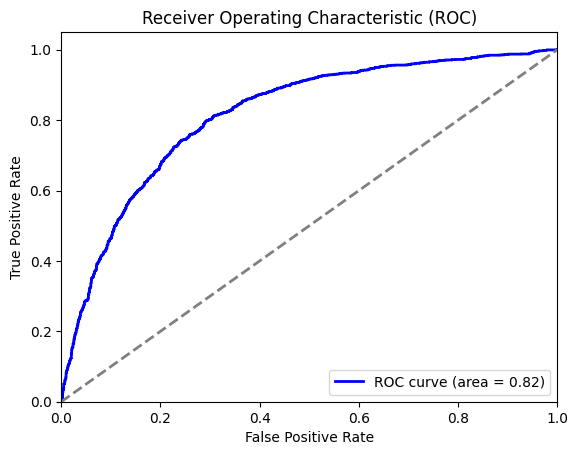

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()